# UTS Deep Learning No.2

Nicholas Sugijono
2602064714

Link Video : https://drive.google.com/file/d/1C2Ywgb8PHlltu1X9MeoPNpCriOuxp6GV/view?usp=sharing

In [55]:
from __future__ import print_function

import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/Dataset2A')

fruit_types = os.listdir('/content/drive/MyDrive/Dataset2A')
print (fruit_types)

print("Types of fruits found: ", len(dataset_path))

['acai', 'acerola', 'apple', 'avocado']
Types of fruits found:  4


## A. Color Histogram

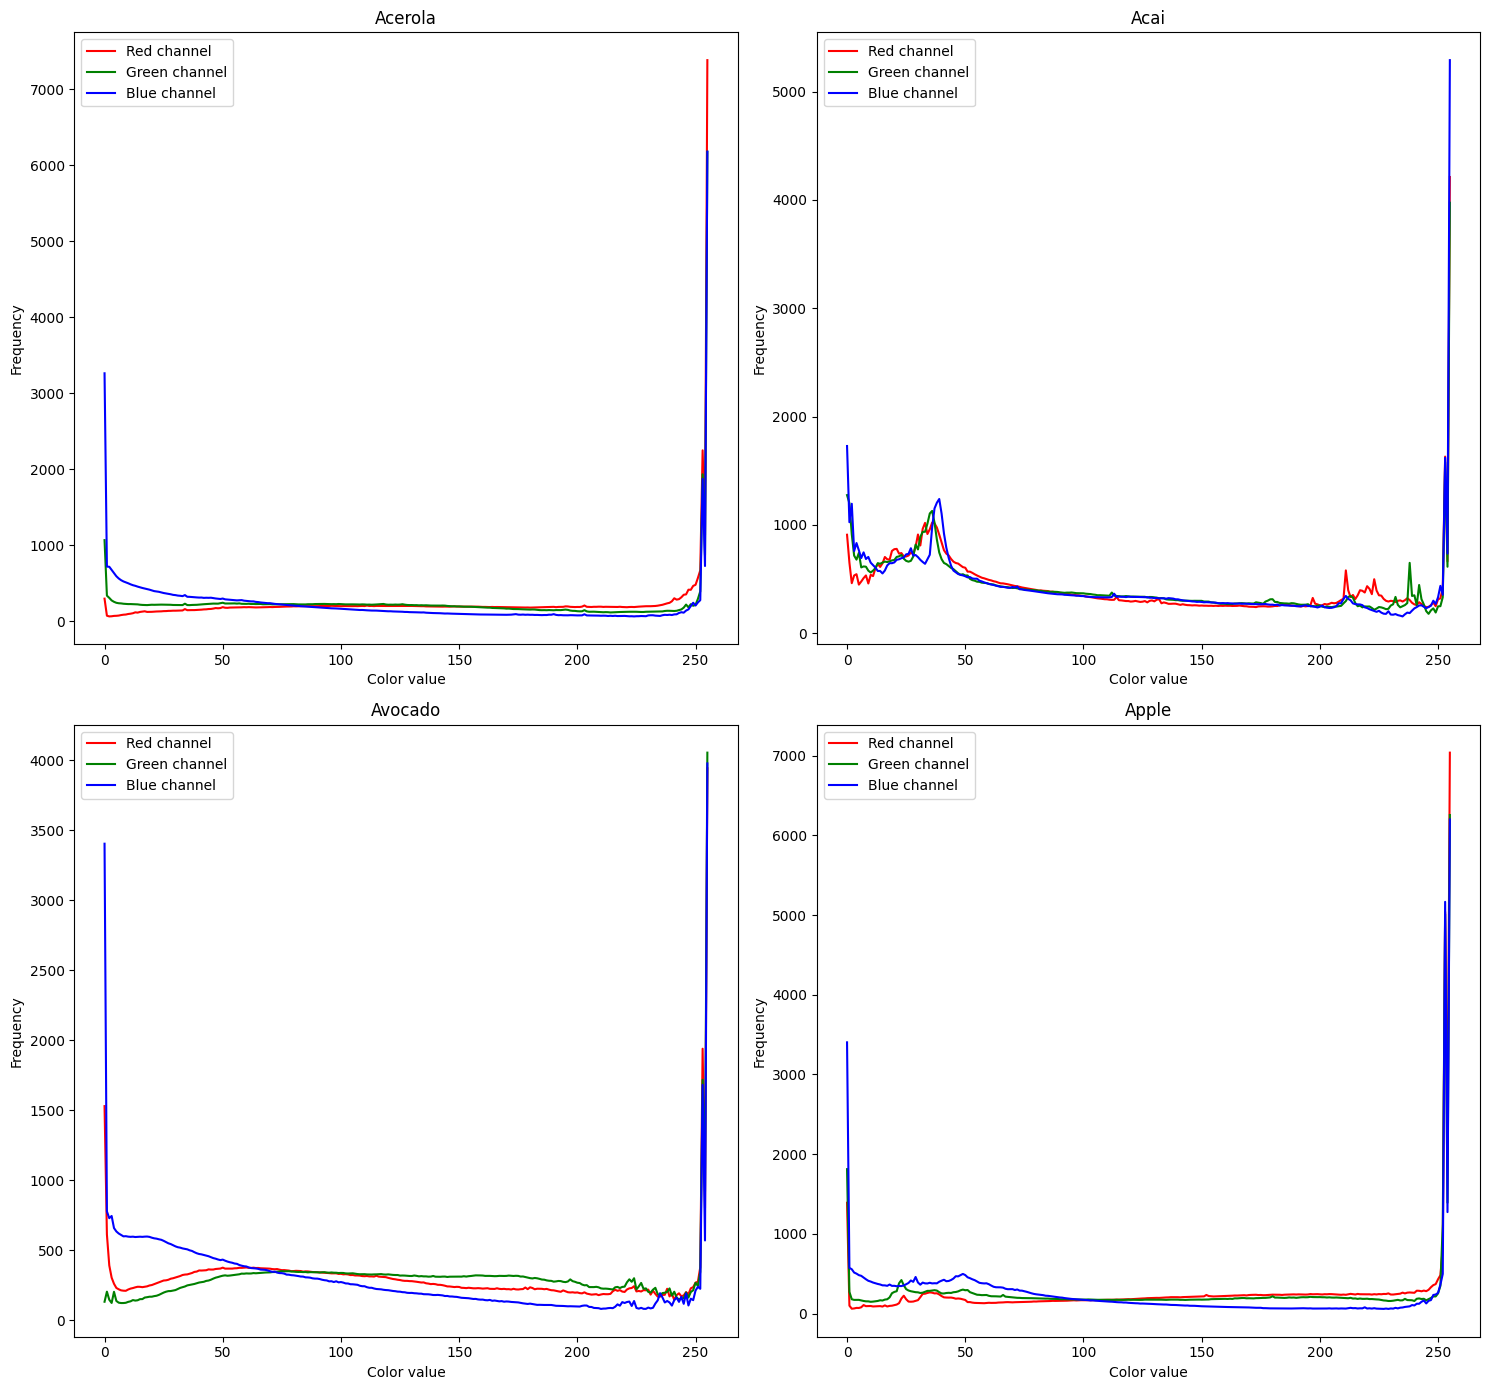

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

path = '/content/drive/MyDrive/Dataset2A'
classes = ['acerola', 'acai', 'avocado', 'apple']


def plot_average_color_histogram(path, classes):
    colors = ('r', 'g', 'b')
    channel_labels = ('Red', 'Green', 'Blue')
    channel_ids = (0, 1, 2)

    num_plots = len(classes)
    num_cols = 2
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7*num_rows))

    for i, fruit in enumerate(classes):
        image_files = [os.path.join(path, fruit, file) for file in os.listdir(os.path.join(path, fruit))]
        histograms = []

        for img_path in image_files:
            img = Image.open(img_path)
            img_array = np.array(img)
            hist_channels = [np.histogram(img_array[:, :, i], bins=256, range=(0, 256))[0]
                             for i in channel_ids]
            histograms.append(hist_channels)

        mean_histograms = np.mean(histograms, axis=0)

        row = i // num_cols
        col = i % num_cols

        for j, (hist, color, label) in enumerate(zip(mean_histograms, colors, channel_labels)):
            ax = axes[row, col]
            ax.plot(range(256), hist, color=color, label=f'{label} channel')
            ax.set_title(f'{fruit.capitalize()}')
            ax.set_xlabel('Color value')
            ax.set_ylabel('Frequency')
            ax.legend()

    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

plot_average_color_histogram(path, classes)



Dari histogram warna untuk setiap label, kita dapat menarik beberapa kesimpulan tentang karakteristik warna dari setiap label:

1. **Label Acerola**:
   - Didominasi oleh warna merah dan biru.
   - Ini menunjukkan bahwa gambar-gambar pada label Acerola memiliki banyak piksel dengan intensitas warna merah dan biru yang tinggi.

2. **Label Acai**:
   - Memiliki warna yang sangat dominan, yaitu biru.
   - Histogram menunjukkan bahwa sebagian besar piksel dalam gambar Acai memiliki intensitas warna biru yang tinggi.

3. **Label Avocado**:
   - Memiliki komposisi warna yang seimbang, menunjukkan keseimbangan warna dalam label.
   - Histogram menunjukkan distribusi intensitas warna yang merata di seluruh rentang warna, tanpa dominasi warna tertentu.
   - Ini menunjukkan bahwa gambar-gambar avocado memiliki beragam warna tanpa ada satu warna yang mendominasi.

4. **Label Apple**:
   - Didominasi oleh warna merah dan biru, mirip dengan label Acerola.
   - Histogram menunjukkan bahwa gambar-gambar pada label Apple memiliki piksel dengan intensitas warna merah dan biru yang tinggi.


In [59]:
fruits = []

for item in fruit_types:

 all_fruit = os.listdir('/content/drive/MyDrive/Dataset2A' + '/' +item)

 for fruit in all_fruit:
    fruits.append((item, str('/content/drive/MyDrive/Dataset2A' + '/' +item) + '/' + fruit))
    print(fruits)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
fruit_df = pd.DataFrame(data=fruits, columns=['fruit type', 'image'])
print(fruit_df.head())

  fruit type                                              image
0       acai  /content/drive/MyDrive/Dataset2A/acai/acai (33...
1       acai  /content/drive/MyDrive/Dataset2A/acai/acai (32...
2       acai  /content/drive/MyDrive/Dataset2A/acai/acai (30...
3       acai  /content/drive/MyDrive/Dataset2A/acai/acai (31...
4       acai  /content/drive/MyDrive/Dataset2A/acai/acai (29...


In [61]:
print("Total number of fruit in the dataset: ", len(fruit_df))

fruit_count = fruit_df['fruit type'].value_counts()

print("fruit in each category: ")
print(fruit_count)

Total number of fruit in the dataset:  1600
fruit in each category: 
fruit type
acai       400
acerola    400
apple      400
avocado    400
Name: count, dtype: int64


In [62]:
import cv2
path = '/content/drive/MyDrive/Dataset2A/'

class_names = os.listdir(path)
num_classes = len(class_names)

img_size = (224,224,3)

images = []
labels = []

for each_class in classes:
  for image in os.listdir(path + '/' + each_class):
    label = np.zeros(num_classes)
    label[class_names.index(each_class)] = 1
    labels.append(label)

    image = np.asarray(cv2.resize(cv2.imread(path + '/' + each_class + '/' + image, cv2.IMREAD_COLOR), img_size[0:2]))
    images.append(image)

## B. Analisis Image Quality

In [63]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_samples(path, class_names, num_samples):
    class_path = os.path.join(path, class_names)
    files = os.listdir(class_path)

    selected_samples = random.sample(files, num_samples)

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, sample in enumerate(selected_samples):
        sample_path = os.path.join(class_path, sample)
        img = mpimg.imread(sample_path)
        axs[i].imshow(img)
        axs[i].set_title(sample)
        axs[i].axis('off')

    fig.suptitle(f'{class_names.upper()}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

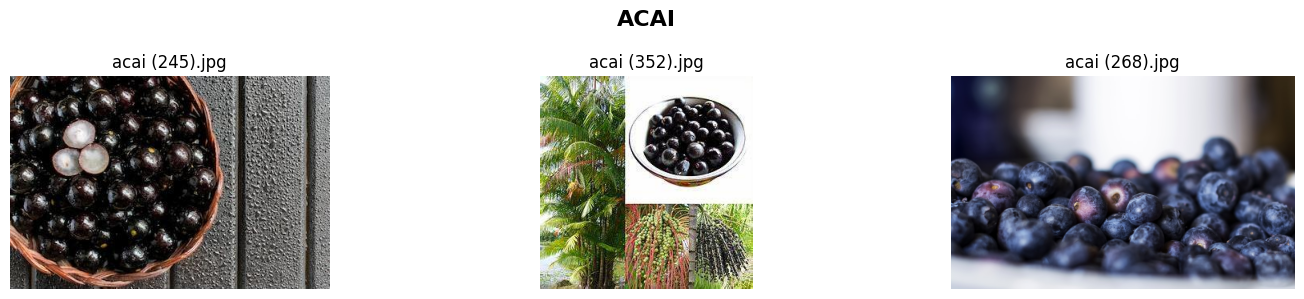

In [64]:
display_samples(path, 'acai', 3)

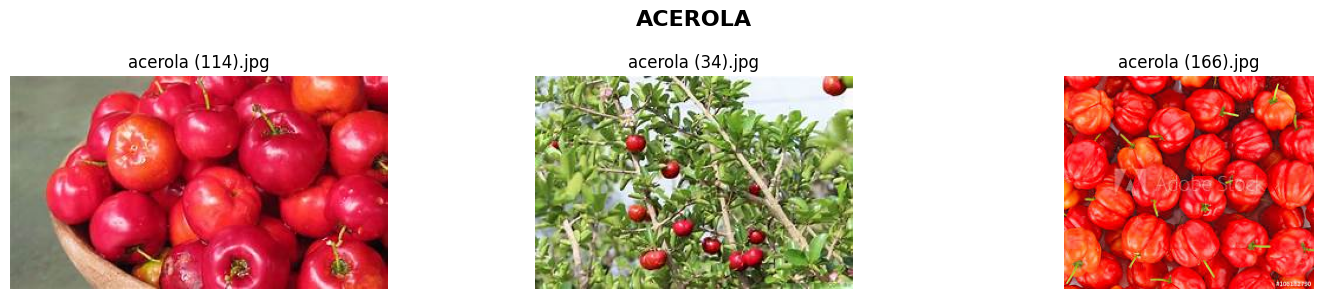

In [65]:
display_samples(path, 'acerola', 3)

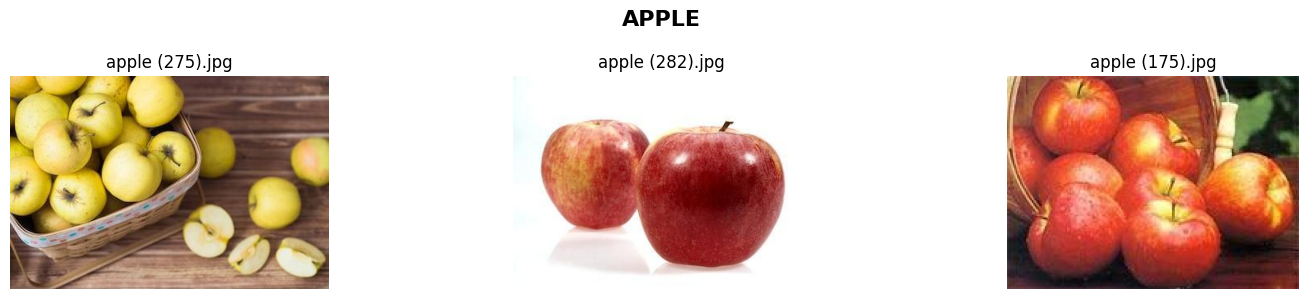

In [66]:
display_samples(path, 'apple', 3)

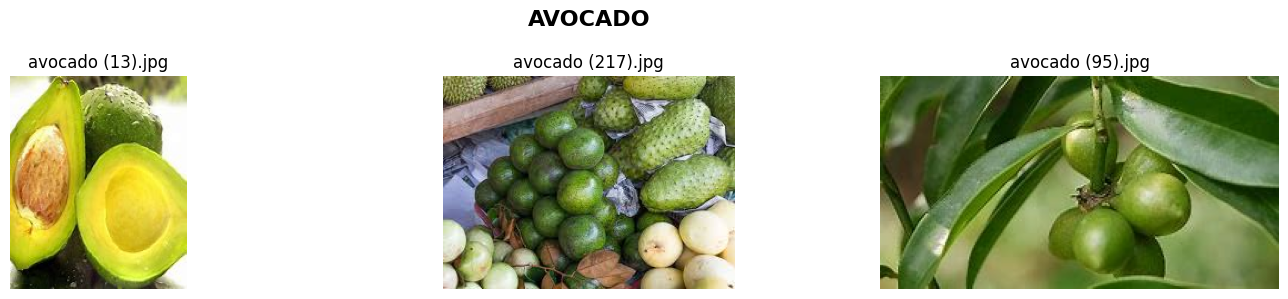

In [67]:
display_samples(path, 'avocado', 3)

Faktor-faktor yang mempengaruhi Image Quality dan hubungannya  adalah :

1. **Resolusi**:
   - **Hubungan dengan Kualitas**: Resolusi yang tinggi cenderung menghasilkan gambar yang lebih tajam dan jelas. Semakin tinggi resolusi, semakin banyak detail yang dapat direkam dalam gambar.
   - **Pengaruh Terhadap Kualitas**: Gambar dengan resolusi rendah mungkin terlihat buram atau kabur, kurang detail, dan kurang tajam.

2. **Noise**:
   - **Hubungan dengan Kualitas**: Noise atau kebisingan mengurangi ketajaman dan detail gambar. Semakin tinggi tingkat kebisingan, semakin buruk kualitas gambar.
   - **Pengaruh Terhadap Kualitas**: Kebisingan dapat mengurangi kualitas gambar dengan membuatnya terlihat kasar atau berbutiran, terutama dalam area dengan kontras rendah atau dalam bayangan.

3. **Pencahayaan**:
   - **Hubungan dengan Kualitas**: Pencahayaan yang baik dapat meningkatkan kualitas gambar dengan menyoroti detail dan warna dengan jelas.
   - **Pengaruh Terhadap Kualitas**: Pencahayaan yang buruk dapat membuat gambar terlihat gelap, bayangan berlebihan, atau overexposed, yang semuanya dapat mengurangi kualitas gambar.

4. **Perspektif dan Sudut**:
   - **Hubungan dengan Kualitas**: Perspektif dan sudut pengambilan gambar dapat mempengaruhi komposisi dan estetika gambar.
   - **Pengaruh Terhadap Kualitas**: Sudut pengambilan gambar yang baik dapat meningkatkan kualitas gambar dengan menyoroti objek utama secara optimal. Sudut yang tidak tepat atau perspektif yang tidak proporsional bisa membuat gambar terlihat tidak seimbang atau tidak menarik.

5. **Variabilitas Latar Belakang**:
   - **Hubungan dengan Kualitas**: Latar belakang yang bervariasi dapat menambah kedalaman dan dimensi pada gambar, memberikan konteks yang lebih kaya.
   - **Pengaruh Terhadap Kualitas**: Latar belakang yang berantakan atau terlalu ramai bisa mengalihkan perhatian dari objek utama, mengurangi kualitas gambar.

Jadi, secara umum, resolusi yang tinggi, tingkat kebisingan yang rendah, pencahayaan yang baik, perspektif dan sudut yang sesuai, serta latar belakang yang variatif, semuanya berkontribusi pada kualitas gambar yang baik. Setiap faktor ini perlu diperhatikan dan diatur dengan baik untuk mendapatkan gambar yang berkualitas.

In [68]:
import os
import random
import cv2
import numpy as np
import skimage
from skimage import io, color, util
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

def evaluate_image(image_path):

    image = cv2.imread(image_path)


    height, width, _ = image.shape
    print("Resolution: {}x{}".format(width, height))


    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    noise = np.mean(np.abs(gray_image - denoised_image))
    print("Noise level:", noise)

    print("Lighting Conditions (Histogram of pixel intensities)")
    plt.hist(gray_image.ravel(), bins=256, range=(0, 255))
    plt.title('Histogram of Pixel Intensities')
    plt.show()

    print("Perspective and Angl e (using ORB)")
    orb = cv2.ORB_create()
    keypoints = orb.detect(gray_image, None)
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2_imshow(image_with_keypoints)

    print("Occlusions, Background Variability, Scale Variations (using Haar Cascade)")
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2_imshow(image)

def evaluate_samples(path, class_names, num_samples_per_class=2):
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        files = os.listdir(class_path)
        selected_samples = random.sample(files, min(num_samples_per_class, len(files)))

        for sample in selected_samples:
            sample_path = os.path.join(class_path, sample)
            evaluate_image(sample_path)
            print("-" * 50)



Resolution: 194x146
Noise level: 33.569340488631546
Lighting Conditions (Histogram of pixel intensities)


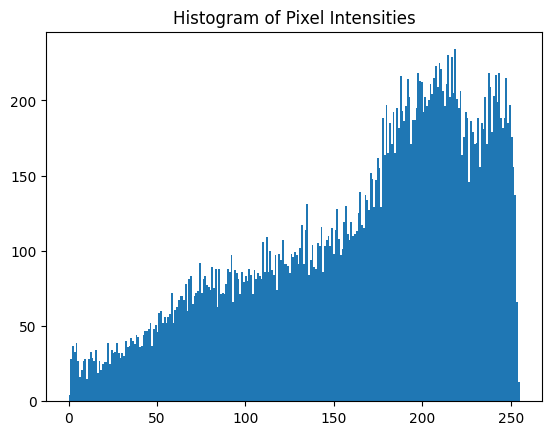

Perspective and Angl e (using ORB)


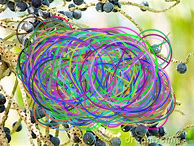

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


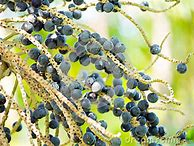

--------------------------------------------------
Resolution: 191x204
Noise level: 73.92372446360743
Lighting Conditions (Histogram of pixel intensities)


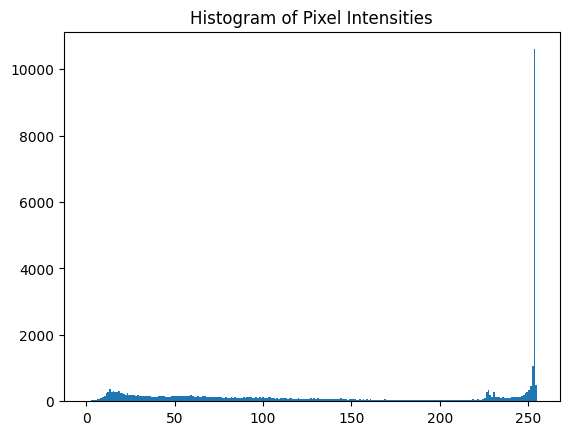

Perspective and Angl e (using ORB)


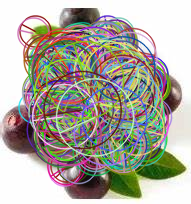

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


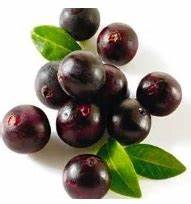

--------------------------------------------------


In [69]:
evaluate_samples(path, ['acai'], num_samples_per_class=2)

Resolution: 390x260
Noise level: 112.31762327416173
Lighting Conditions (Histogram of pixel intensities)


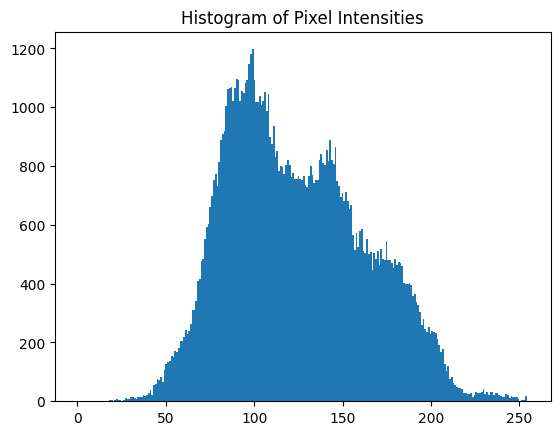

Perspective and Angl e (using ORB)


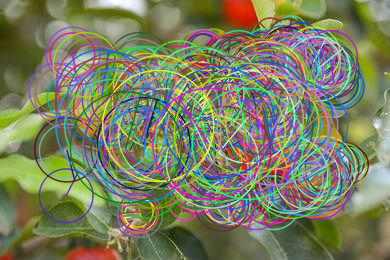

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


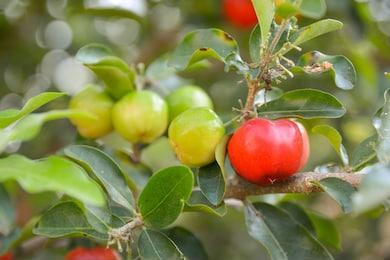

--------------------------------------------------
Resolution: 241x161
Noise level: 111.24558645395737
Lighting Conditions (Histogram of pixel intensities)


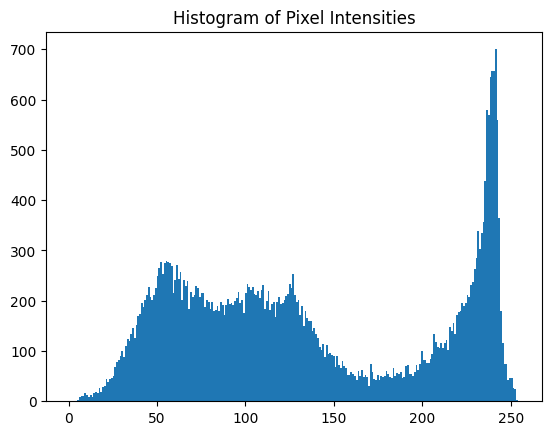

Perspective and Angl e (using ORB)


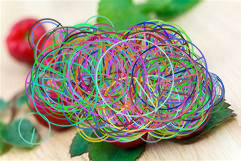

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


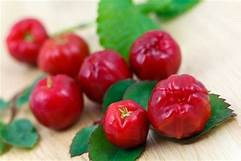

--------------------------------------------------


In [70]:
evaluate_samples(path, ['acerola'], num_samples_per_class=2)

Resolution: 190x180
Noise level: 107.06143274853801
Lighting Conditions (Histogram of pixel intensities)


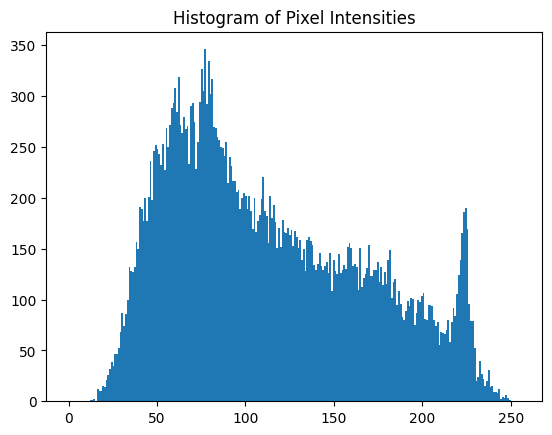

Perspective and Angl e (using ORB)


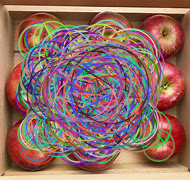

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


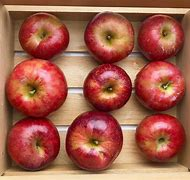

--------------------------------------------------
Resolution: 275x183
Noise level: 114.70322901142573
Lighting Conditions (Histogram of pixel intensities)


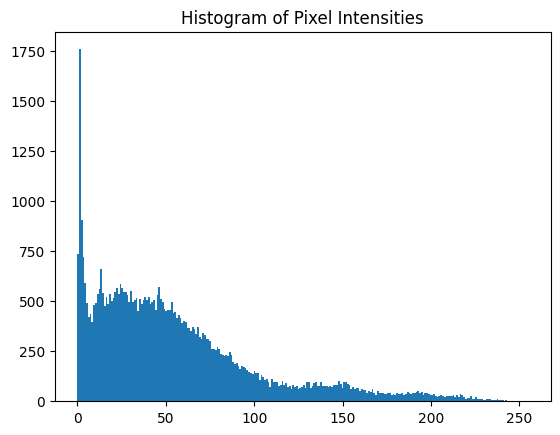

Perspective and Angl e (using ORB)


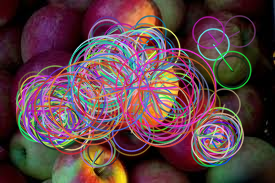

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


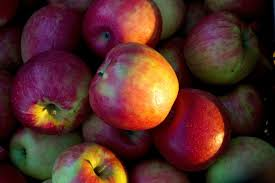

--------------------------------------------------


In [71]:
evaluate_samples(path, ['apple'], num_samples_per_class=2)

Resolution: 216x162
Noise level: 68.82333104709647
Lighting Conditions (Histogram of pixel intensities)


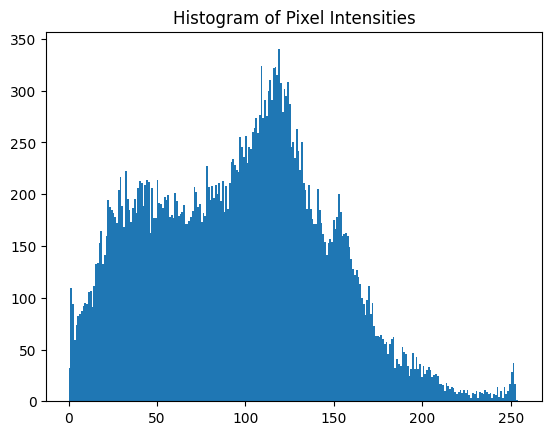

Perspective and Angl e (using ORB)


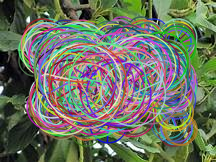

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


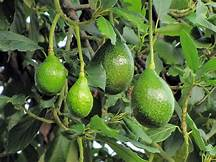

--------------------------------------------------
Resolution: 225x225
Noise level: 114.52811851851853
Lighting Conditions (Histogram of pixel intensities)


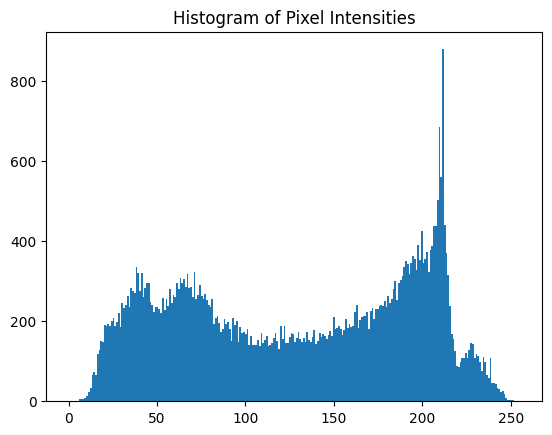

Perspective and Angl e (using ORB)


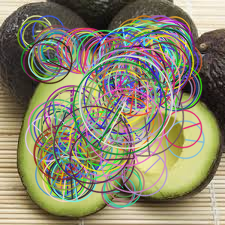

Occlusions, Background Variability, Scale Variations (using Haar Cascade)


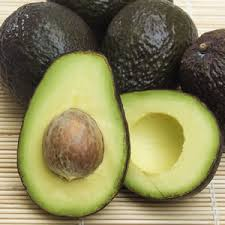

--------------------------------------------------


In [72]:
evaluate_samples(path, ['avocado'], num_samples_per_class=2)

Dari hasil analisis keseluruhan untuk kualitas gambar, kita dapat membuat beberapa kesimpulan penting:

1. **Resolusi Gambar**:
   - Resolusi pada gambar sudah cukup tinggi, yang akan diubah menjadi 224x224.

2. **Noise pada Gambar**:
   - Noise pada gambar sangat bervariasi, di mana beberapa gambar memiliki tingkat noise yang tinggi (lebih dari 100) dan beberapa lainnya memiliki tingkat noise yang rendah (kurang dari 40).
   - Tingkat noise yang tinggi dapat mempengaruhi kualitas gambar dan kemampuan model untuk mengenali objek dengan tepat.

3. **Lighting Conditions**:
   - Mayoritas gambar memiliki pixel intensity yang cukup tinggi, cenderung berada di rentang antara 200 hingga 250. Ini menunjukkan bahwa kondisi pencahayaan dalam gambar secara umum cukup baik.
   - Pixel intensity yang tinggi dapat membantu dalam memperjelas detail objek dan membuatnya lebih mudah untuk dikenali oleh model.

4. **Perspective Angle**:
   - Dalam mendeteksi objek menggunakan ORB, mayoritas gambar memiliki kualitas yang baik dalam mendeteksi objek buahnya.
   - Sudut pandang yang baik memungkinkan model untuk mendapatkan informasi yang cukup untuk mengenali objek dengan tepat.

5. **Background Variability**:
   - Beberapa gambar masih memiliki background yang ramai atau memiliki objek lain yang terdeteksi.
   - Background yang ramai atau adanya objek lain yang terdeteksi dapat mengganggu proses pengenalan objek, karena model mungkin akan memperhatikan objek-objek tambahan tersebut.

In [73]:
labels_array = np.asarray(labels)
images_array = np.asarray(images)

print("Labels Shape : ", labels_array.shape)
print("Images Shape : ", images_array.shape)

Labels Shape :  (1600, 4)
Images Shape :  (1600, 224, 224, 3)


In [74]:
images_array = images_array.astype('float32') / 255.0
images_array.shape

(1600, 224, 224, 3)

In [75]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(images_array, labels_array, test_size = 0.1, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

In [76]:
print("Train Images Shape      : ", x_train.shape)
print("Train Labels Shape      : ", y_train.shape)
print("Test Images Shape       : ", x_test.shape)
print("Test Labels Shape       : ", y_test.shape)
print("Validation Images Shape : ", x_valid.shape)
print("Validation Labels Shape : ", y_valid.shape)

Train Images Shape      :  (1296, 224, 224, 3)
Train Labels Shape      :  (1296, 4)
Test Images Shape       :  (144, 224, 224, 3)
Test Labels Shape       :  (144, 4)
Validation Images Shape :  (160, 224, 224, 3)
Validation Labels Shape :  (160, 4)


In [77]:
import tensorflow as tf

train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, vertical_flip = True)
train_images_generator = train_images_generator.flow(x_train, y = y_train)

valid_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip = True)
valid_images_generator = valid_images_generator.flow(x_valid, y = y_valid)

## C. Arsitektur Baseline

In [78]:
from keras.models import Sequential, Model

model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation="relu"),
    Conv2D(128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation="relu"),
    Conv2D(256, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    Flatten(),

    Dense(4096, activation="relu"),
    Dense(4096, activation="relu"),
    Dense(4, activation="softmax")
])

Model ini menggunakan 16 layer konvolusi dimana pada 2 layer pertama digunakan 64 filter yang menunjukan berapa banyak fitur yang akan diekstraksi dari gambar dan kernel size 3x3, yang akan menggunakan area 3x3 untuk mengidentifikasi pola dan menggunakan fungsi aktivasi relu yang mengubah semua nilai negatif menjadi 0. dan dilanjutkan dengan Max Pooling yang digunakan untuk mengurangi dimensi dari representasi fitur dalam gambar, ukuran 2x2 menunjukan bahwa jendela 2x2 akan bergeser untuk mencari nilai terbesar dalam setiap jendela.
untuk 2 layer selanjutnya hanya ditambahkan kernel menjadi 128 lalu 256 dan 4 layer terakhir 512 kernel.

In [79]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [80]:
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 10)

Epoch 1/10
41/41 [==============================] - 17s 327ms/step - loss: 1.5526 - accuracy: 0.2323 - val_loss: 1.3883 - val_accuracy: 0.2625
Epoch 2/10
41/41 [==============================] - 13s 322ms/step - loss: 1.3883 - accuracy: 0.2623 - val_loss: 1.3911 - val_accuracy: 0.2000
Epoch 3/10
41/41 [==============================] - 13s 323ms/step - loss: 1.3868 - accuracy: 0.2623 - val_loss: 1.3921 - val_accuracy: 0.2000
Epoch 4/10
41/41 [==============================] - 13s 322ms/step - loss: 1.5466 - accuracy: 0.2654 - val_loss: 1.3911 - val_accuracy: 0.2000
Epoch 5/10
41/41 [==============================] - 13s 321ms/step - loss: 1.3862 - accuracy: 0.2623 - val_loss: 1.3928 - val_accuracy: 0.2000
Epoch 6/10
41/41 [==============================] - 13s 317ms/step - loss: 1.4644 - accuracy: 0.2569 - val_loss: 1.3935 - val_accuracy: 0.2000
Epoch 7/10
41/41 [==============================] - 13s 309ms/step - loss: 1.3870 - accuracy: 0.2623 - val_loss: 1.3896 - val_accuracy: 0.2000

In [81]:
test_loss , test_accuracy = model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 80ms/step - loss: 1.3898 - accuracy: 0.1944


In [82]:
print("Model Accuracy", test_accuracy)
print("Model Loss", test_loss)

Model Accuracy 0.1944444477558136
Model Loss 1.3898154497146606


Model VGG-16 mungkin kurang cocok dengan dataset ini karena fitur-fitur yang dipelajarinya mungkin terlalu umum dan ukuran modelnya yang besar bisa menyebabkan overfitting pada dataset yang relatif kecil. Oleh karena itu, untuk memaksimalkan kinerja model, kita perlu mempertimbangkan penggunaan model yang lebih sesuai dengan karakteristik data yang dimiliki.

## D. Modifikasi Arsitektur

In [83]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.2),
    Dense(4096, activation="relu"),
    Dropout(0.2),
    Dense(4, activation="sigmoid")
])


Dalam code baru ini saya menambahkan dan mengganti beberapa hal yaitu:
- Menambahkan Batch Normalization, dengan tujuan menormalisasi setiap outputnya dengan mengskala setiap fitur, membantu stabilitas pada fitur, serta regularisasi
- Menambahkan Dropout(0.2), dengan tujuan mencegah overfitting dengan melakukan regularisasi dalam model, dan mengurangi ketergantungan, serta meingkatkan robustness untuk memastikan satu neuron tidak berkontribusi pada prediksi keseluruhan
- Same padding, yaitu lapisan akan menambahkan padding ke input yang akan memiliki dimensi yang sama dengan input, bertujuan untuk mengurangi informasi yang hilang.

In [84]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [85]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=25)


Epoch 1/25
41/41 [==============================] - 29s 607ms/step - loss: 19.0848 - accuracy: 0.3588 - val_loss: 1.4380 - val_accuracy: 0.3625
Epoch 2/25
41/41 [==============================] - 24s 596ms/step - loss: 0.8854 - accuracy: 0.6559 - val_loss: 2.0150 - val_accuracy: 0.2000
Epoch 3/25
41/41 [==============================] - 24s 593ms/step - loss: 0.7110 - accuracy: 0.7153 - val_loss: 1.8066 - val_accuracy: 0.2625
Epoch 4/25
41/41 [==============================] - 24s 595ms/step - loss: 0.6939 - accuracy: 0.7438 - val_loss: 2.7161 - val_accuracy: 0.2937
Epoch 5/25
41/41 [==============================] - 24s 597ms/step - loss: 0.6854 - accuracy: 0.7515 - val_loss: 2.1544 - val_accuracy: 0.2000
Epoch 6/25
41/41 [==============================] - 24s 594ms/step - loss: 0.5952 - accuracy: 0.7816 - val_loss: 2.0252 - val_accuracy: 0.2000
Epoch 7/25
41/41 [==============================] - 24s 592ms/step - loss: 0.6119 - accuracy: 0.7747 - val_loss: 1.8355 - val_accuracy: 0.287

## E. Performance Evaluation

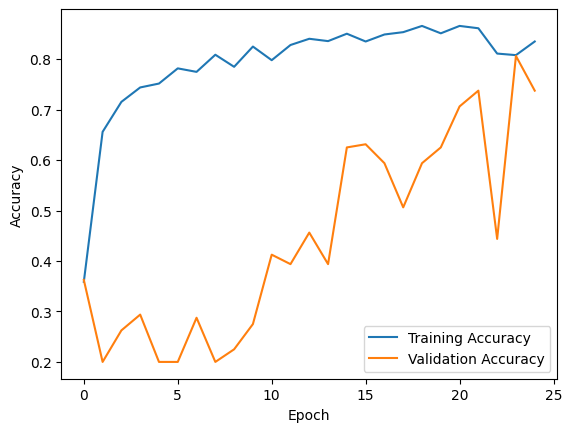

In [86]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

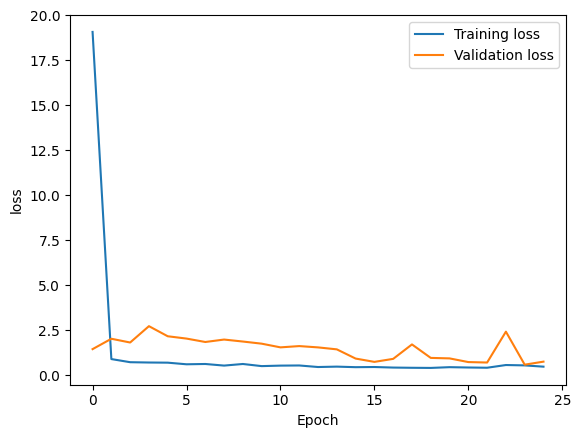

In [87]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [88]:
test_loss , test_accuracy = model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 104ms/step - loss: 0.7398 - accuracy: 0.8056


In [89]:
print("Model Accuracy", test_accuracy)
print("Model Loss", test_loss)

Model Accuracy 0.8055555820465088
Model Loss 0.7397772669792175



Kesimpulan dari model ini adalah bahwa meskipun terdapat peningkatan dalam train accuracy dan penurunan train loss dibandingkan dengan model sebelumnya, namun terdapat kecenderungan bahwa model ini terlalu kompleks. Hal ini terindikasi dari fakta bahwa meskipun train metrics (akurasi dan loss) menunjukkan kinerja yang lebih baik, validation loss yang tinggi dan validation accuracy yang rendah menunjukkan bahwa model belum mampu melakukan generalisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

Meskipun model memiliki kemampuan untuk mempelajari fitur-fitur yang kompleks dari data pelatihan, tetapi kemampuannya untuk menggeneralisasi ke data baru masih terbatas. Ini dapat disebabkan oleh terlalu banyaknya parameter dalam model atau oleh kurangnya variasi dalam data pelatihan yang diberikan ke model.